# Taller de visión por ordenador aplicado a la apicultura

## Importar librerías

In [2]:
#!pip install -r requirements.txt

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

## Análisis de Imágenes

Cargamos la foto con la función de la librería de opencv. Hay que tener en cuenta que opencv trabaja en **BGR**.

In [6]:
name = "1"
img = cv2.imread("fotos/"+name+'.JPG')

Definimos una función para mostar las imágenes.

In [10]:
def show_img(img, title='img', inline=True):
    if inline == True:
        aux = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(aux)
    else:
        cv2.imshow(title, img)
        cv2.waitKey()
        cv2.destroyAllWindows()

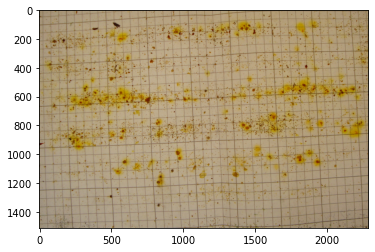

In [13]:
show_img(img)

### Procesado

#### Visualizar gráficas

In [19]:
def calcHistogram(img, canal=0):
    height = 0
    width = 0
    gray = False
    try:
        height, width, channels = img.shape
    except ValueError:
        height, width = img.shape
        gray = True
    histArray =  []
    for x in range(255):
        histArray.append(0)
    for i in range(height):
        for j in range(width):
            if gray:
                histArray[int(img.item(i,j))] += 1
            else:
                histArray[int(img.item(i,j,canal))] += 1
    return histArray

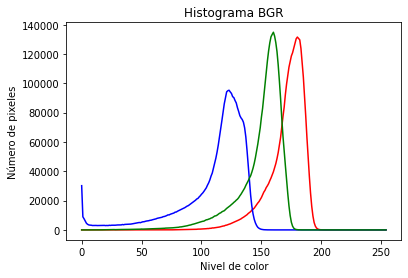

In [35]:
histRed = calcHistogram(img, 2)
plt.plot(histRed, color='red')
histBlue = calcHistogram(img, 0)
plt.plot(histBlue, color='blue')
histGreen = calcHistogram(img, 1)
plt.plot(histGreen, color='green')
plt.title("Histograma BGR")
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.show()

#### Extraer canal rojo

Ponemos a cero todos los canales excepto el rojo, para así resaltar los puntos mas rojizos, ya que las varroas tienen una tonalidad roja.

In [23]:
red = img.copy()
red[:,:,0] = 0
red[:,:,1] = 0

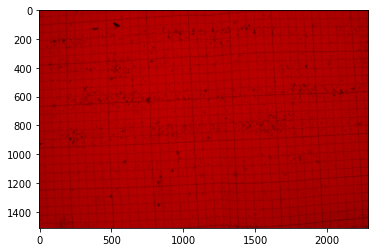

In [24]:
show_img(red)

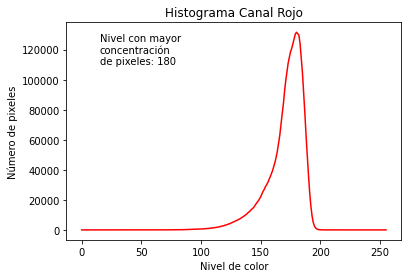

In [42]:
opencvHistRed = cv2.calcHist([img],[2], None, [256],[0,256])
plt.plot(opencvHistRed, color='red')
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.title("Histograma Canal Rojo")
idmax = np.argmax(opencvHistRed, axis=0)[0]
plt.text(15, 110000, "Nivel con mayor\nconcentración\nde pixeles: "+str(idmax))
plt.show()

In [43]:
print("Nivel con mayor concentración de pixeles: "+str(idmax))

Nivel con mayor concentración de pixeles: 180


#### Binarizar

##### Algoritmo del mínimo error de Kittler e Illingworth.

Método de umbralización de imagenes, es decir, bsuqueda del umbral óptimo que permita separar los objetos de primer plano del fondo.

<img src="imgs/formulas_1.PNG"/>
<img src="imgs/formulas_2.PNG"/>

In [45]:
def kittler(im, out):
    """Algoritmo de Mínimo Error de Kittler e Illingworth


    Arguments:
    im -- imagen en escala de grises
    out -- kernel donde estará la imagen de salida
    """

    np.seterr(divide='ignore', invalid='ignore')
    h, g = np.histogram(im.ravel(), 256, [0, 256])
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p = c / c[-1]
    v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - \
        p*np.log(p) - (1-p)*np.log(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    out[:, :] = 0
    out[im >= t] = 255

A partir de la imagen con el canal rojo aislado, binarizamos la imagen

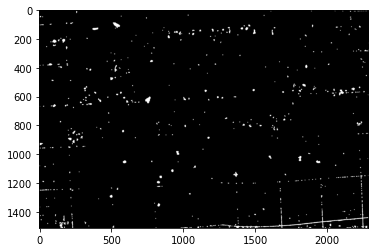

In [46]:
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(red, kernel, iterations=1)
erosion = cv2.erode(dilation, kernel, iterations=1)
median = cv2.medianBlur(erosion, 3)
gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
out = np.empty_like(gray)
kittler(gray, out)
out = cv2.bitwise_not(out)
#h, hp, res = deleteLines(out)
show_img(out)

#### Eliminar las lineas

##### Algoritmo Canny

In [48]:
dst = cv2.Canny(out, 50, 200, None, 3)
res = out.copy()

linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

for i in range(0, len(linesP)):
    l = linesP[i][0]
    cv2.line(res, (l[0], l[1]), (l[2], l[3]), (0,0,0), 10, cv2.LINE_AA)

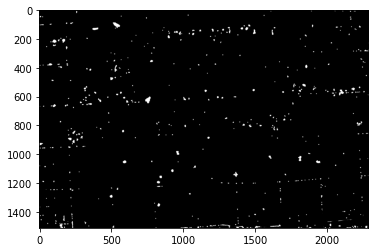

In [49]:
show_img(res)